<a href="https://colab.research.google.com/github/GaliKavyaSuma/Malicious-URL-detection/blob/main/MUD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import itertools
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from lightgbm import LGBMClassifier
import os
import seaborn as sns
from wordcloud import WordCloud

In [2]:
# Read the CSV file into a DataFrame
df=pd.read_csv('/content/malicious_phish.csv')
# Print the shape of the DataFrame (number of rows, number of columns)
print(df.shape)
# Display the first few rows of the DataFrame
df.head()

(651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [3]:
# Count the occurrences of each unique value in the 'type' column of the DataFrame 'df'
# and return the counts as a Series
df.type.value_counts()

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

# Plotting Wordcloud

In [4]:
df_phish = df[df.type=='phishing']
df_malware = df[df.type=='malware']
df_deface = df[df.type=='defacement']
df_benign = df[df.type=='benign']

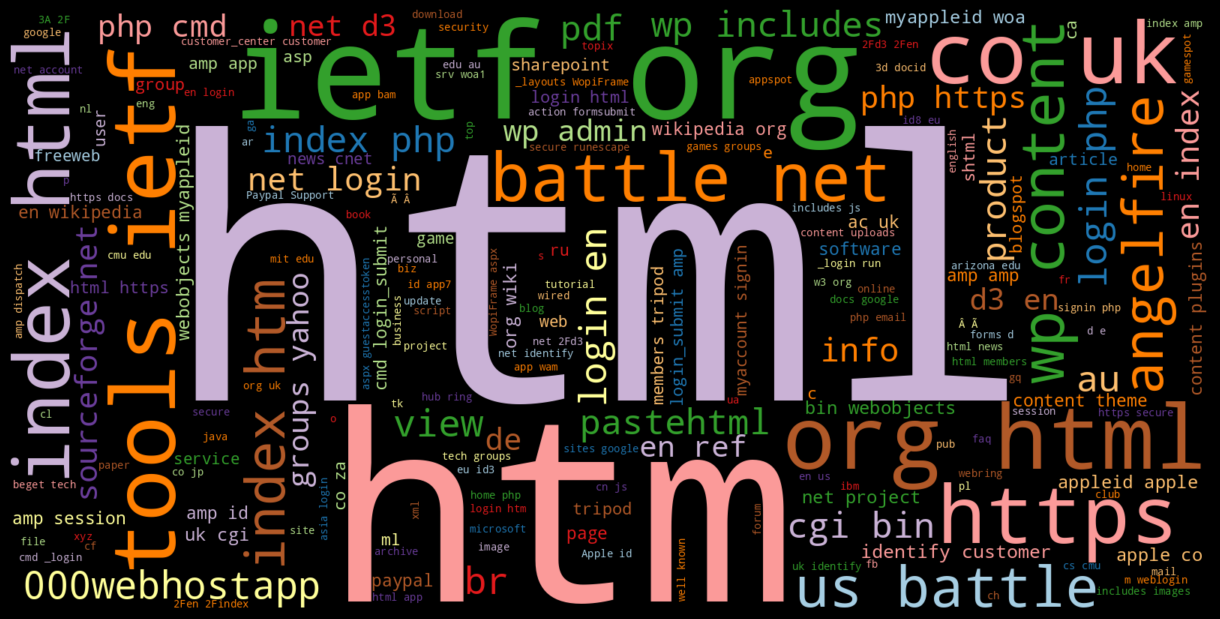

In [5]:
phish_url = " ".join(i for i in df_phish.url)   # Join all URLs in the 'url' column of the DataFrame 'df_phish' into a single string
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(phish_url)   # Generate a word cloud from the joined URLs
plt.figure( figsize=(12,14),facecolor='k')      # Create a new figure with specified size and background color
plt.imshow(wordcloud, interpolation='bilinear')    # Display the word cloud with bilinear interpolation
plt.axis("off")                                    # Turn off the axis
plt.tight_layout(pad=0)                            # Adjust layout to eliminate padding
plt.show()                                         # Show the word cloud

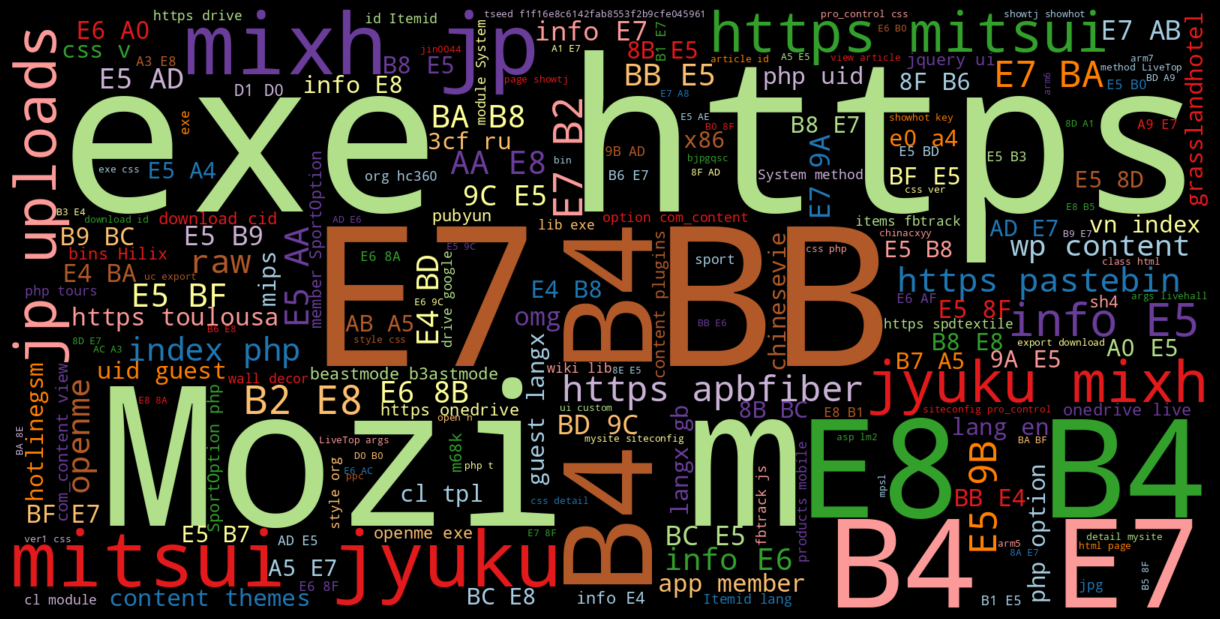

In [6]:
malware_url = " ".join(i for i in df_malware.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(malware_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

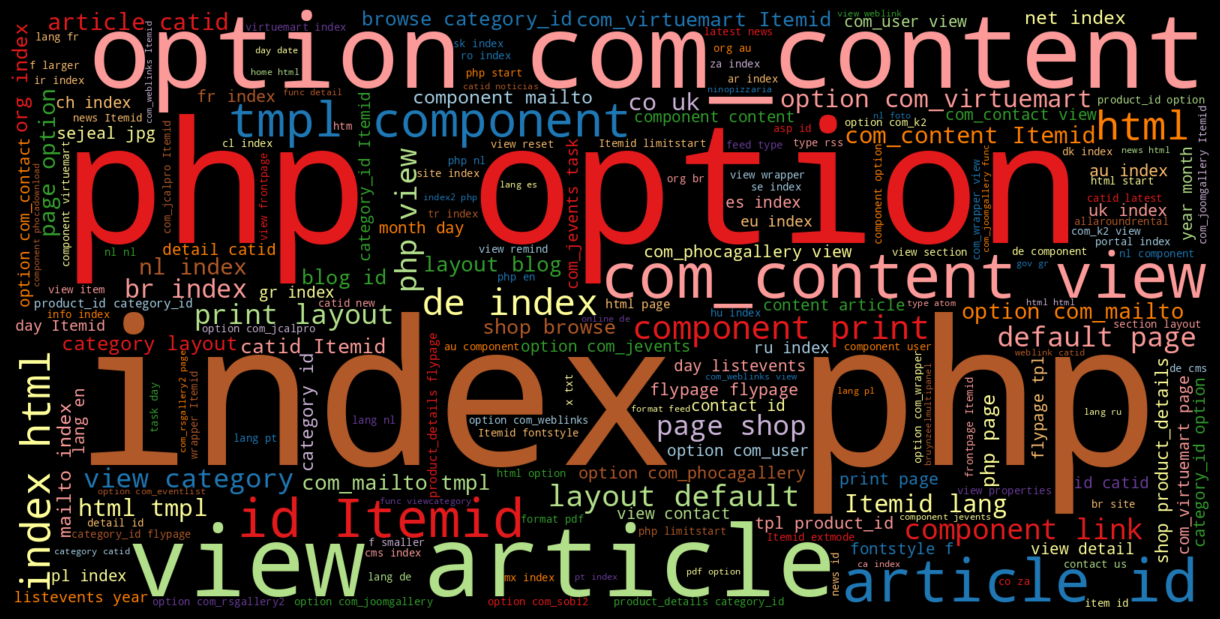

In [7]:
deface_url = " ".join(i for i in df_deface.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(deface_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

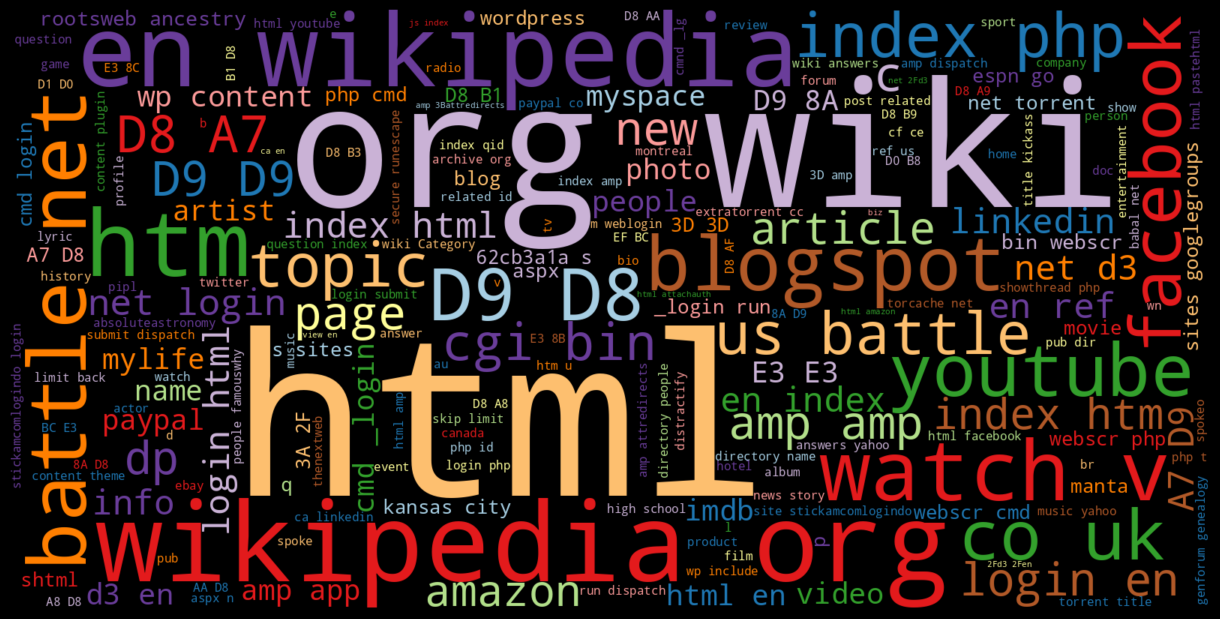

In [8]:
benign_url = " ".join(i for i in df_benign.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(benign_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Feature Engineering

In [9]:
import re
#Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))

In [10]:
from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

In [11]:
#!pip install googlesearch-python

In [12]:
from googlesearch import search

In [13]:
def google_index(url):
    site = search(url, 5)
    return 1 if site else 0
df['google_index'] = df['url'].apply(lambda i: google_index(i))

In [14]:
def count_dot(url):
    count_dot = url.count('.')
    return count_dot

df['count.'] = df['url'].apply(lambda i: count_dot(i))
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.
0,br-icloud.com.br,phishing,0,0,1,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2


In [15]:
#Hostname Length

def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))

df.head()

def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits


df['count-digits']= df['url'].apply(lambda i: digit_count(i))

In [16]:
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,hostname_length,sus_url,count-digits
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,1
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,21,0,7
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,23,0,22


In [17]:
!pip install tld

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 3.5 MB/s eta 0:00:00


In [18]:
#Importing dependencies
from urllib.parse import urlparse
from tld import get_tld
import os.path

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

#Length of Top Level Domain
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))


def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

In [19]:
df = df.drop("tld",axis=1)

In [20]:
df.columns

Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'hostname_length', 'sus_url', 'count-digits', 'fd_length',
       'tld_length'],
      dtype='object')

In [21]:
df['type'].value_counts()

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

# EDA
# 1. Distribution of use_of_ip

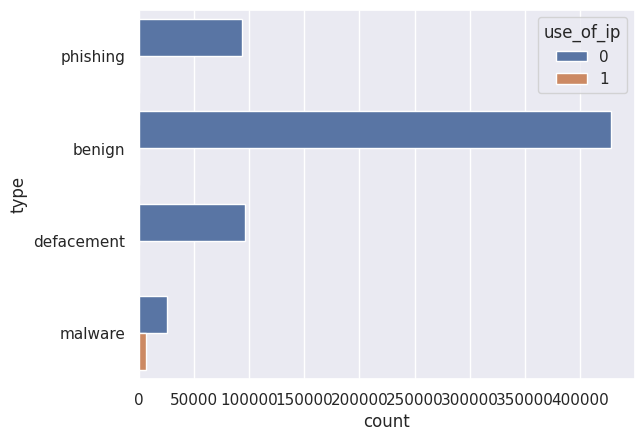

In [22]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="use_of_ip")

# 2. Distribution of abnormal url

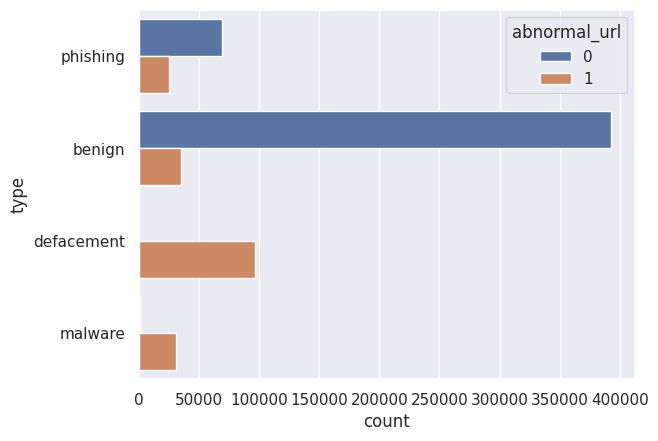

In [23]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="abnormal_url")

# 3. Distribution of Google Index

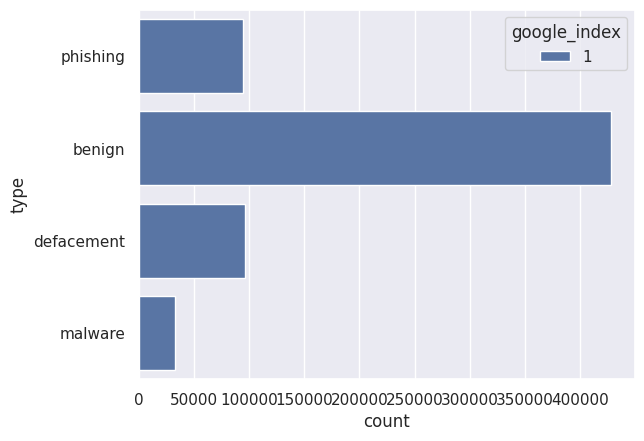

In [24]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="google_index")

# 4. Distribution of Suspicious URL

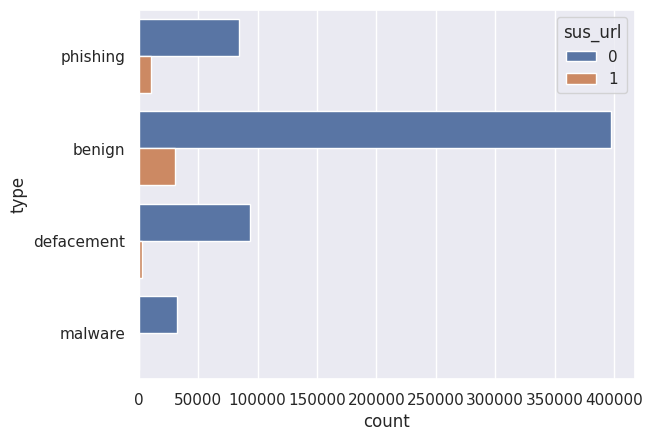

In [25]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="sus_url")

# 5. Distribution of hostname length

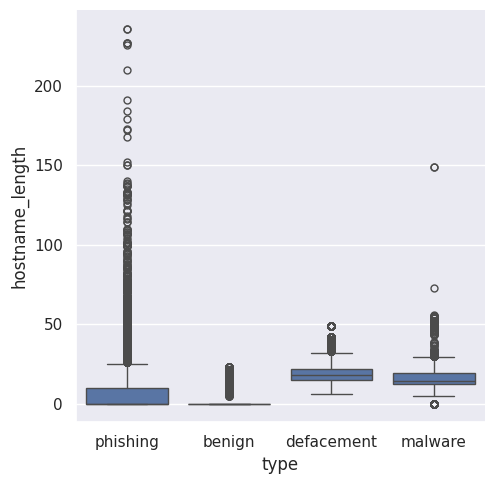

In [26]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="hostname_length", kind="box", data=df)

# 6. Distribution of first directory length

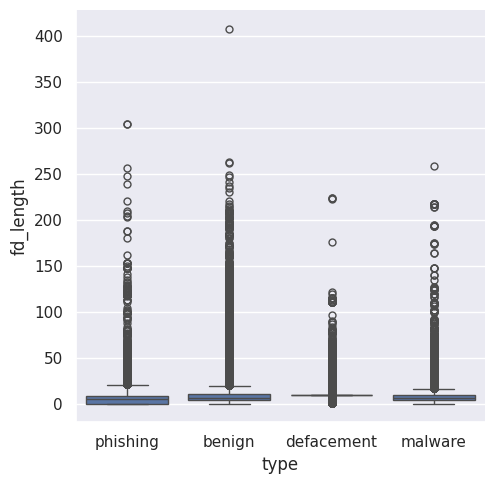

In [27]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="fd_length", kind="box", data=df)

# 7. Distribution of top-level domain length

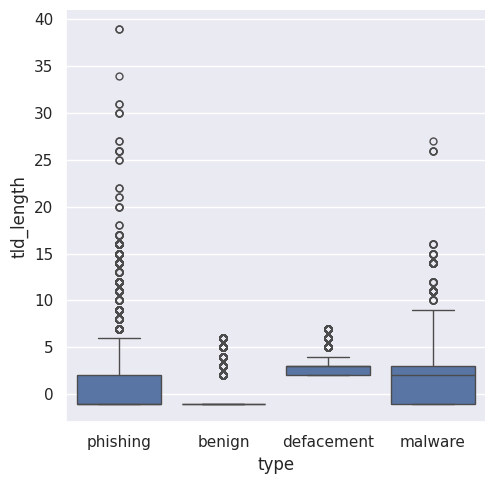

In [28]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="tld_length", kind="box", data=df)

# Target Encoding

In [29]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])
df["type_code"].value_counts()

type_code
0    428103
1     96457
3     94111
2     32520
Name: count, dtype: int64

# Creation of Feature & Target

In [30]:
#Predictor Variables
# filtering out google_index as it has only 1 value
X = df[['use_of_ip','abnormal_url','hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',]]

#Target Variable
y = df['type_code']

In [ ]:
X.head()

,use_of_ip,abnormal_url,hostname_length,sus_url,fd_length,tld_length,count-digits
0,0,0,0,0,0,-1,0
1,0,0,0,0,5,-1,1
2,0,0,0,0,7,-1,1
3,0,1,21,0,9,2,7
4,0,1,23,0,9,3,22


In [31]:
X.columns

Index(['use_of_ip', 'abnormal_url', 'hostname_length', 'sus_url', 'fd_length',
       'tld_length', 'count-digits'],
      dtype='object')

# Train Test Split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.4,shuffle=True, random_state=5)

# Model Building
# 1. Random Forest Classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
rf = RandomForestClassifier(n_estimators=100,max_features='sqrt')
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test,y_pred_rf,target_names=['benign', 'defacement','phishing','malware']))

score = metrics.accuracy_score(y_test, y_pred_rf)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.86      0.99      0.92    171242
  defacement       0.92      0.95      0.94     38583
    phishing       0.93      0.89      0.91     13008
     malware       0.78      0.22      0.35     37644

    accuracy                           0.87    260477
   macro avg       0.87      0.76      0.78    260477
weighted avg       0.86      0.87      0.84    260477

accuracy:   0.867


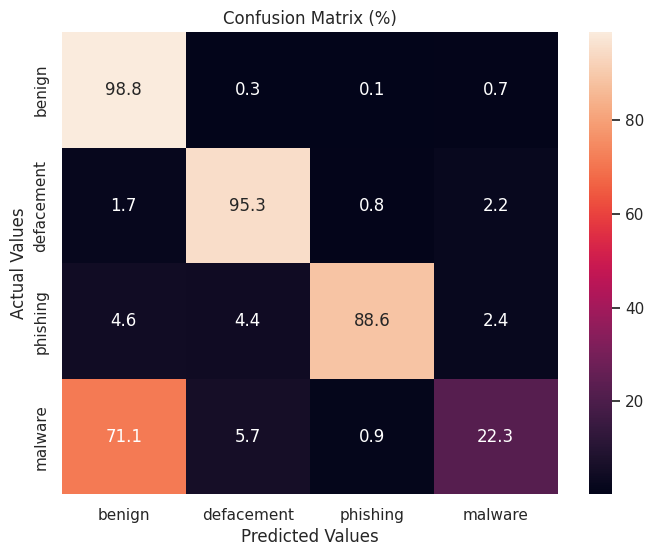

In [34]:
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Compute percentages
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_percentage = cm / cm_sum.astype(float) * 100

# Create DataFrame
cm_df_percentage = pd.DataFrame(cm_percentage,
                                index=['benign', 'defacement', 'phishing', 'malware'],
                                columns=['benign', 'defacement', 'phishing', 'malware'])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df_percentage, annot=True, fmt=".1f")
plt.title('Confusion Matrix (%)')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


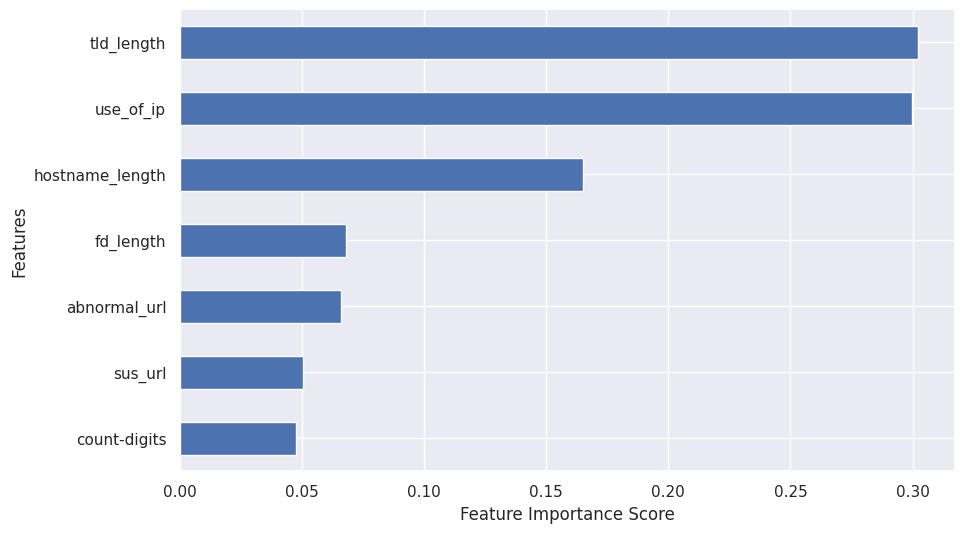

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier  # Import XGBClassifier

# Assuming X_train and y_train are already defined

# Initialize and fit XGBoost classifier
xgb_c = XGBClassifier()  # Create an instance of the classifier
xgb_c.fit(X_train, y_train)  # Train the classifier

# Rest of your code remains the same
feat_importances = pd.Series(xgb_c.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh", figsize=(10, 6))
plt.xlabel('Feature Importance Score')  # Label for x-axis
plt.ylabel('Features')  # Label for y-axis
plt.show()

# 2. Light GBM Classifier

In [38]:
lgb = LGBMClassifier(objective='multiclass',boosting_type= 'gbdt',n_jobs = 5,
          silent = True, random_state=5)
LGB_C = lgb.fit(X_train, y_train)


y_pred_lgb = LGB_C.predict(X_test)
print(classification_report(y_test,y_pred_lgb,target_names=['benign', 'defacement','phishing','malware']))

score = metrics.accuracy_score(y_test, y_pred_lgb)
print("accuracy:   %0.3f" % score)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 409
[LightGBM] [Info] Number of data points in the train set: 390714, number of used features: 7
[LightGBM] [Info] Start training from score -0.419441
[LightGBM] [Info] Start training from score -1.909708
[LightGBM] [Info] Start training from score -2.996946
[LightGBM] [Info] Start training from score -1.934319
[LightGBM] [Warning] Unknown parameter: silent
              precision    recall  f1-score   support

      benign       0.85      0.99      0.92    171242
  defacement       0.88      0.95      0.92     38583
    phishing       0.93      0.83      0.88     13008
     malware       0.79      0.19      0.30     37644

    accuracy                           0.86    260477
   macro avg       0.86      

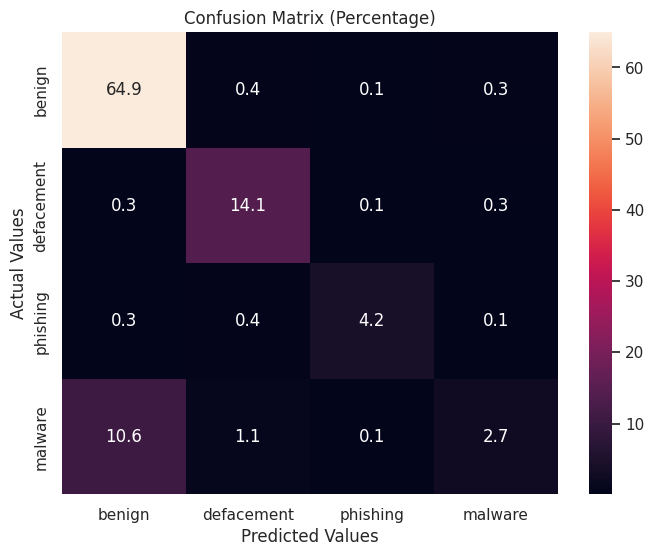

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have already defined y_test and y_pred_lgb
cm = confusion_matrix(y_test, y_pred_lgb)

# Calculate the total number of observations
total_observations = np.sum(cm)

# Convert values in the confusion matrix to percentages
cm_percentage = (cm / total_observations) * 100

# Create a DataFrame for the confusion matrix with labels
cm_df = pd.DataFrame(cm_percentage,
                     index=['benign', 'defacement', 'phishing', 'malware'],
                     columns=['benign', 'defacement', 'phishing', 'malware'])

# Plot the heatmap with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt=".1f")
plt.title('Confusion Matrix (Percentage)')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


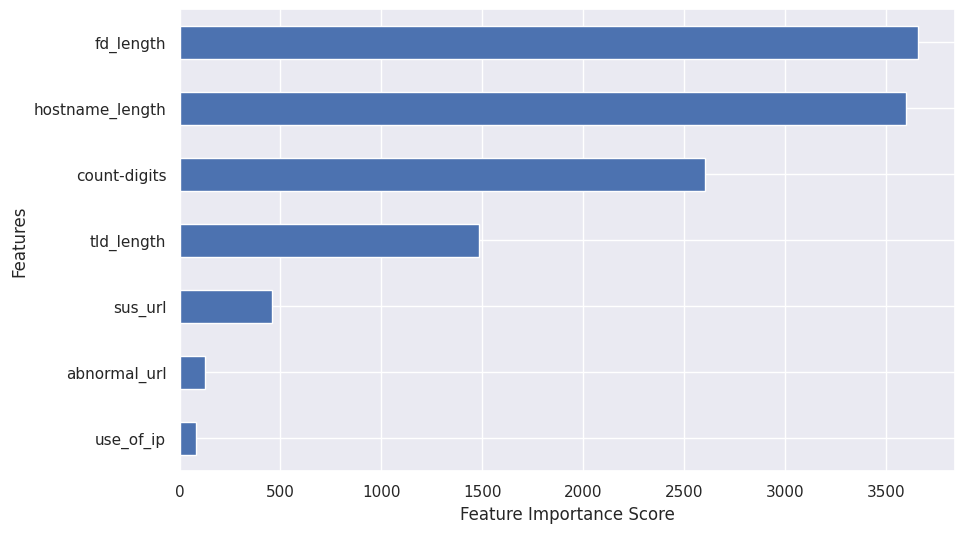

In [40]:
feat_importances = pd.Series(lgb.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh", figsize=(10, 6))
plt.xlabel('Feature Importance Score')  # Label for x-axis
plt.ylabel('Features')  # Label for y-axis
plt.show()


# 3. XGboost Classifier

In [41]:
xgb_c = xgb.XGBClassifier(n_estimators= 100)
xgb_c.fit(X_train,y_train)
y_pred_x = xgb_c.predict(X_test)
print(classification_report(y_test,y_pred_x,target_names=['benign', 'defacement','phishing','malware']))


score = metrics.accuracy_score(y_test, y_pred_x)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.85      0.99      0.92    171242
  defacement       0.89      0.96      0.92     38583
    phishing       0.94      0.84      0.89     13008
     malware       0.80      0.19      0.31     37644

    accuracy                           0.86    260477
   macro avg       0.87      0.74      0.76    260477
weighted avg       0.86      0.86      0.83    260477

accuracy:   0.861


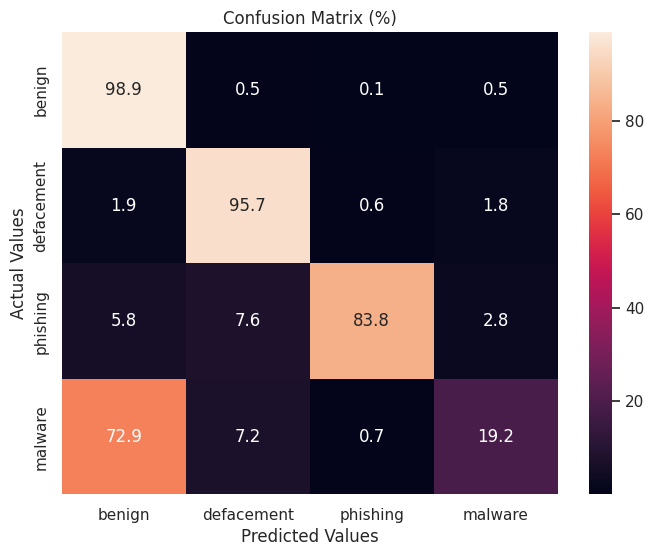

In [42]:
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_x)

# Compute percentages
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_percentage = cm / cm_sum.astype(float) * 100

# Create DataFrame
cm_df_percentage = pd.DataFrame(cm_percentage,
                                index=['benign', 'defacement', 'phishing', 'malware'],
                                columns=['benign', 'defacement', 'phishing', 'malware'])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df_percentage, annot=True, fmt=".1f")
plt.title('Confusion Matrix (%)')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


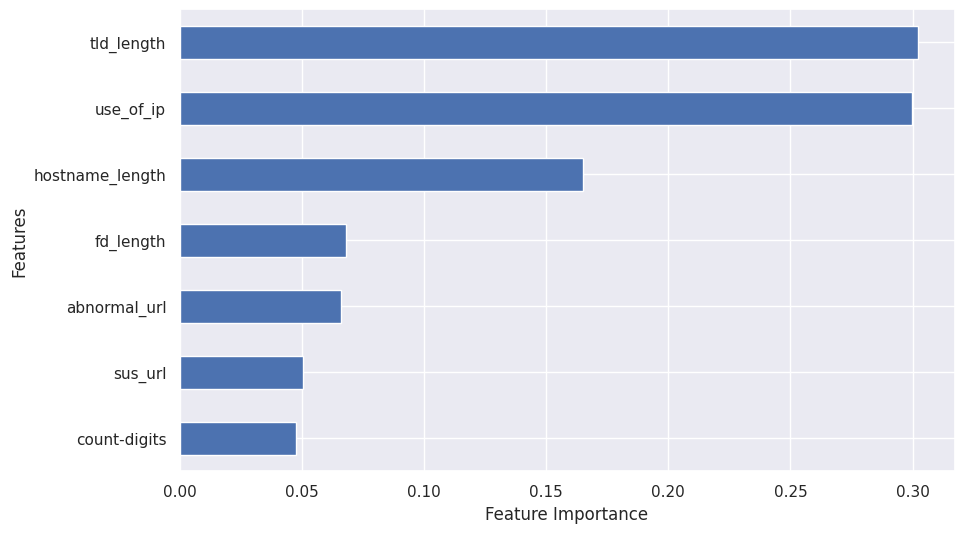

In [43]:
import matplotlib.pyplot as plt

feat_importances = pd.Series(xgb_c.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh", figsize=(10, 6))
plt.xlabel('Feature Importance')  # Label for x-axis
plt.ylabel('Features')  # Label for y-axis
plt.show()

# Prediction

In [44]:
def main(url):

    status = []

    status.append(having_ip_address(url))
    status.append(abnormal_url(url))
    status.append(hostname_length(url))
    status.append(suspicious_words(url))
    status.append(digit_count(url))
    status.append(fd_length(url))
    tld = get_tld(url,fail_silently=True)

    status.append(tld_length(tld))




    return status

In [45]:
def get_prediction_from_url(test_url):
    features_test = main(test_url)
    # Due to updates to scikit-learn, we now need a 2D array as a parameter to the predict function.
    features_test = np.array(features_test).reshape((1, -1))



    pred = xgb_c.predict(features_test)
    if int(pred[0]) == 0:

        res="SAFE"
        return res
    elif int(pred[0]) == 1.0:

        res="DEFACEMENT"
        return res
    elif int(pred[0]) == 2.0:
        res="PHISHING"
        return res

    elif int(pred[0]) == 3.0:

        res="MALWARE"
        return res

In [46]:
urls = ['uk.linkedin.com/pub/steve-rubenstein/8/718/755','strawberrycreekgardens.com/','http://www.artedesignsas.it/catalogo.html?page=shop.browse&category_id=14','http://www.bimabn.com/1-configurazione-supporto-apple.store-contatta/c/Apple-id/3d465e25b47e6bc23ae55f5de40e1bb1/','halkbankparaf-para.com','hallmark.businessgreetings.com/']
for url in urls:
     print(get_prediction_from_url(url))

SAFE
SAFE
MALWARE
MALWARE
MALWARE
SAFE
